# 基础概念

## 距离度量

分为欧氏距离、街区距离和棋盘距离

## 线性操作和非线性操作

一般的，图像可以被解释为一个矩阵，对矩阵的线性操作应该满足**齐性**和**加性**：
    $$
        H[a_i f_i(x, y) + a_j f_j(x, y)] = a_i H[f_i(x, y)] + a_j H[f_j(x, y)] = a_i g_i(x, y) + a_j g_j(x, y)
    $$
    
## 图像的算术运算

### 针对降噪的带噪图像相加（平均）

书中给出了一个很有趣的例子，多幅带噪声的图像求取均值可以得到原来的图像。下面来试验一下：

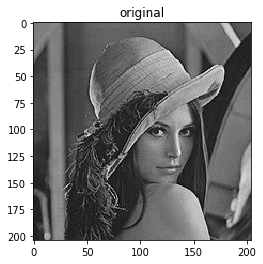

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
img = cv.imread('lena.jpg', 0)
plt.imshow(img, cmap = 'gray')
plt.title('original')
plt.show()

噪声模型不明白，这里就给一个比较简单的加噪方法：

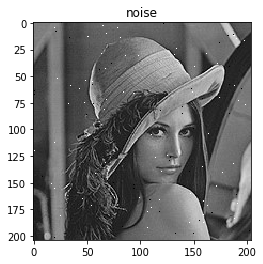

In [2]:
import numpy.random as nr
def noise_img(pic):
    t_mat = pic.copy()
    def inner():
        n = nr.randint(0, 100)
        x = nr.randint(0, t_mat.shape[0], n)
        y = nr.randint(0, t_mat.shape[1], n)
        return (x, y)
    t_mat[inner()] = 0
    t_mat[inner()] = 255
    return t_mat
plt.imshow(noise_img(img), cmap = 'gray')
plt.title('noise')
plt.show()

定义了加噪方法之后，将多幅噪声平均化：

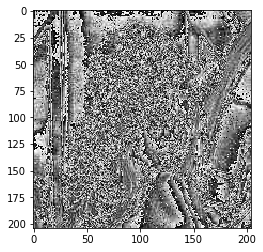

In [3]:
def avg_noise(n):
    t = noise_img(img)
    for i in range(n - 1):
        t = t + noise_img(img)
    t = t / n
    return t
plt.imshow(avg_noise(10), cmap = 'gray')
plt.show()

发现这种方法失效了。这是因为上述实现的噪声是**椒盐噪声**，而不符合平均去噪中的加性噪声的条件，所以不能实现图像还原。

而加性噪声中最常见的一种是**高斯白噪声**，这涉及到后面的知识，所以这里用matlab产生一系列高斯噪声图像，只看一下它们平均化的结果：

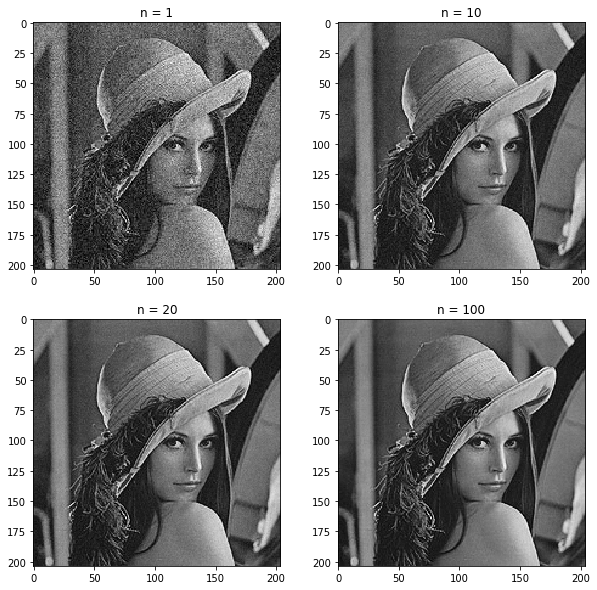

In [97]:
def avg_noise(n):
    imgs = np.array([cv.imread('.\\noise\\' + str(i) + '.jpg', 0) for i in range(1, n + 1)])
    return imgs.mean(axis = 0)
plt.figure(figsize = (10, 10))
plt.subplot(221)
plt.imshow(avg_noise(1), cmap = 'gray')
plt.title('n = 1')
plt.subplot(222)
plt.imshow(avg_noise(10), cmap = 'gray')
plt.title('n = 10')
plt.subplot(223)
plt.imshow(avg_noise(20), cmap = 'gray')
plt.title('n = 20')
plt.subplot(224)
plt.imshow(avg_noise(100), cmap = 'gray')
plt.title('n = 100')
plt.show()

可以看到，图像变得清晰了。

### 图像相减

通过将两幅图像相减，可以显示出两幅图像中不同的地方。以上面所提到的加噪图片为例：

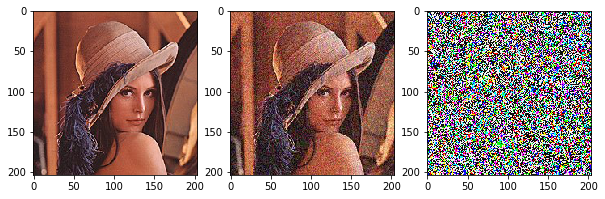

In [98]:
img1 = cv.imread('lena.jpg')
img2 = cv.imread('.\\noise\\1.jpg')
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
plt.figure(figsize = (10, 10))
plt.subplot(131)
plt.imshow(img1)
plt.subplot(132)
plt.imshow(img2)
plt.subplot(133)
plt.imshow(img1 - img2)
plt.show()

得到的就是加上的噪声图像。当有两张很相似的图片需要找不同的时候，就可以使用图像相减的方法得到不同之处。

### 图像乘除

算术乘除操作是不均匀的，会使得对比度拉大（或减小），所以可以起到阴影校正的作用。

## 图像的集合操作

这里举一个负片的例子：所谓负片，就是照片在胶卷上显示的图像。要从一张正常图片得到负片，可以将这个过程表述为集合操作中的求**补集(complement set)**，在matlab中，`imcomplement`就是求负片的函数

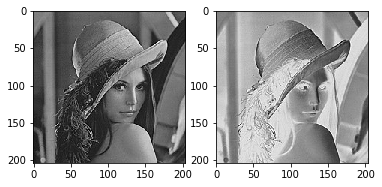

In [6]:
img = cv.imread('lena.jpg', 0)
plt.subplot(121)
plt.imshow(img, cmap = 'gray')
img = 255 - img # 求补集
plt.subplot(122)
plt.imshow(img, cmap = 'gray')
plt.show()

## 空间操作

### 单像素操作

比如刚刚的求负片的操作，就是一个单像素操作

### 领域操作

领域操作以一个坐标点周围的一个领域为依据产生结果图片。输入一个点集，输出一个坐标点。比如可以通过求一个小邻域（$2\times 2$）均值的方法，得到一张模糊图像：

In [99]:
def expand(mat, n):
    # 按正方形对图片拓展
    res = mat.copy()
    row, col = res.shape
    res = np.vstack((np.zeros((n, col)), res, np.zeros((n, col))))
    res = np.hstack((np.zeros((row + 2 * n, n)), res, np.zeros((row + 2 * n, n))))
    return res

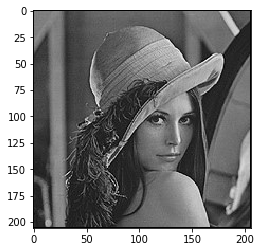

In [100]:
img = cv.imread('lena.jpg', 0)
img = expand(img, 1)
plt.imshow(img, cmap = 'gray')
plt.show()

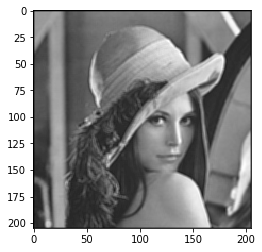

In [101]:
def blur(pic):
    row, col = pic.shape
    res = np.zeros((row - 1, col - 1))
    for i in range(1, row - 1):
        for j in range(1, col - 1):
            res[i, j] = pic[i - 1 : i + 2, j - 1 : j + 2].mean()
            # 求区域均值
    return res
plt.imshow(blur(img), cmap = 'gray')
plt.show()

可以看到，相比较于原图像，现在的图像变得模糊了。

### 几何空间变换和图像配准

这种变换方式是对原图像像素点的操作，可以实现对图像的尺度变换、旋转、平移或偏移，统称为**仿射**。

$$
    (x, y) = T\{(v, w)\}\Rightarrow [x\ y\ 1] = [v\ w\ 1]
    \left[
    \begin{matrix}
        t_{11} & t_{12} & 0\\
        t_{21} & t_{22} & 0\\
        t_{31} & t_{32} & 0
    \end{matrix}
    \right]
$$

我们先将图像拓展，便于观察变换的结果：

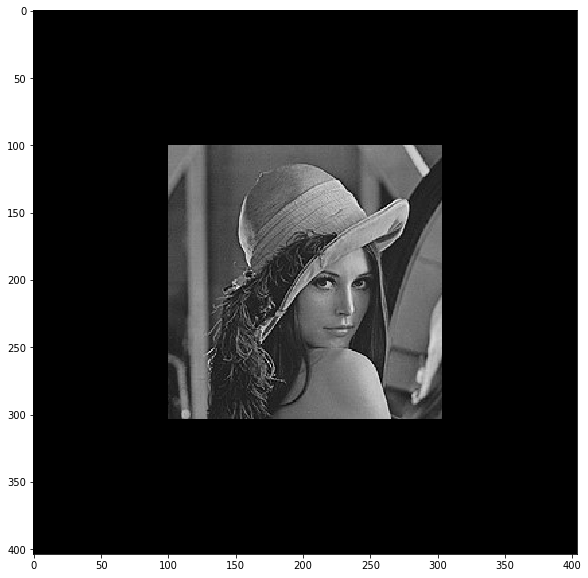

In [102]:
img = cv.imread('lena.jpg', 0)
i, j = img.shape
n = 100
area = (n, n + i, n, n + j)
img = expand(img, n)
plt.figure(figsize = (10, 10))
plt.imshow(img, cmap = 'gray')
plt.show()

下面用两种方法实现仿射变换。

经过两种实验可以看到，**前向映射**的结果图片有失真，但是**反向映射**就没有。这里的原因很好解释：在前向映射中，因为坐标取整的问题，输出图片并不能保证每一个像素都可以被映射到。但经过反向映射，输出图片的每一个像素点都是经过计算的。

所以现在的图像处理函数大多使用反向映射来实现仿射变换。

In [107]:
def transform(pic, area, Delta):
    # area: tuple(row_begin, row_end, col_begin, col_end)
    # 前向映射
    res = np.zeros(pic.shape)
    for v in range(area[0], area[1]):
        for w in range(area[2], area[3]):
            x, y, _ = np.dot([v, w, 1], Delta) # 注意：A*B在numpy中代表元素乘
            res[int(x), int(y)] = pic[v, w]
    return res

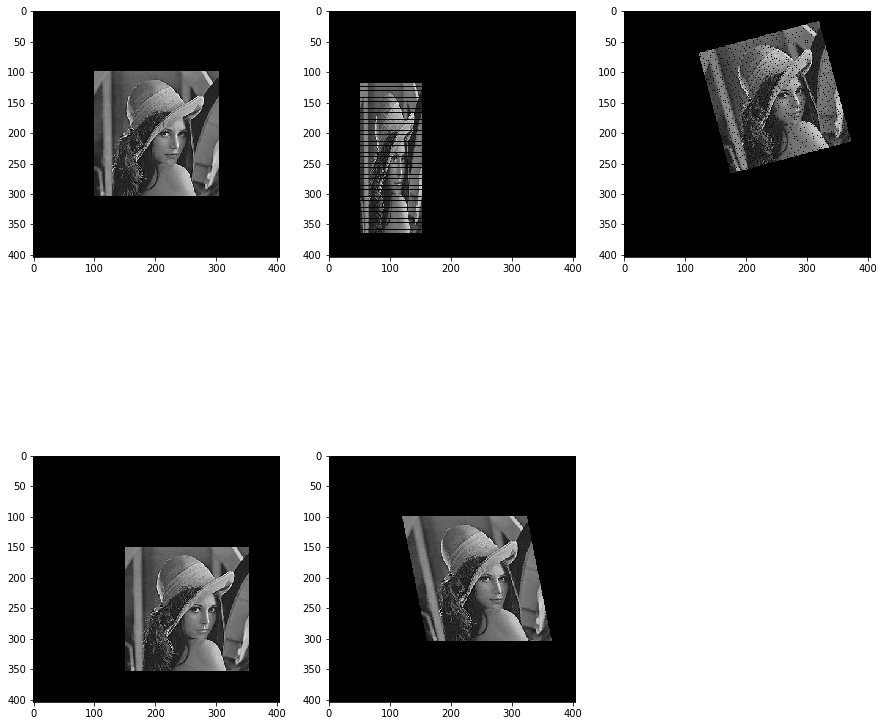

In [108]:
plt.figure(figsize = (15, 15))
# 恒等变换
Delta = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
plt.subplot(231)
plt.imshow(transform(img, area, Delta), cmap = 'gray')
# 尺度变换
Delta = np.array([[1.2, 0, 0], [0, 0.5, 0], [0, 0, 1]])
plt.subplot(232)
plt.imshow(transform(img, area, Delta), cmap = 'gray')
# 旋转变换
deg = np.pi / 12
Delta = np.array([[np.cos(deg), np.sin(deg), 0], [-np.sin(deg), np.cos(deg), 0], [0, 0, 1]])
plt.subplot(233)
plt.imshow(transform(img, area, Delta), cmap = 'gray')
# 平移变换
Delta = np.array([[1, 0, 0], [0, 1, 0], [50, 50, 1]])
plt.subplot(234)
plt.imshow(transform(img, area, Delta), cmap = 'gray')
# 偏移变换
Delta = np.array([[1, 0.2, 0], [0, 1, 0], [0, 0, 1]])
plt.subplot(235)
plt.imshow(transform(img, area, Delta), cmap = 'gray')
plt.show()

In [109]:
def transform(pic, area, Delta):
    # area: tuple(row_begin, row_end, col_begin, col_end)
    # 反向映射
    delta_inv = np.matrix(Delta).I
    res = np.zeros(pic.shape)
    row, col = pic.shape
    for x in range(row):
        for y in range(col):
            p1, p2, _ = np.dot([x, y, 1], np.array(delta_inv))
            if p1 > 0 and p1 < row and p2 > 0 and p2 < col:
                res[x, y] = pic[int(p1), int(p2)]
    return res

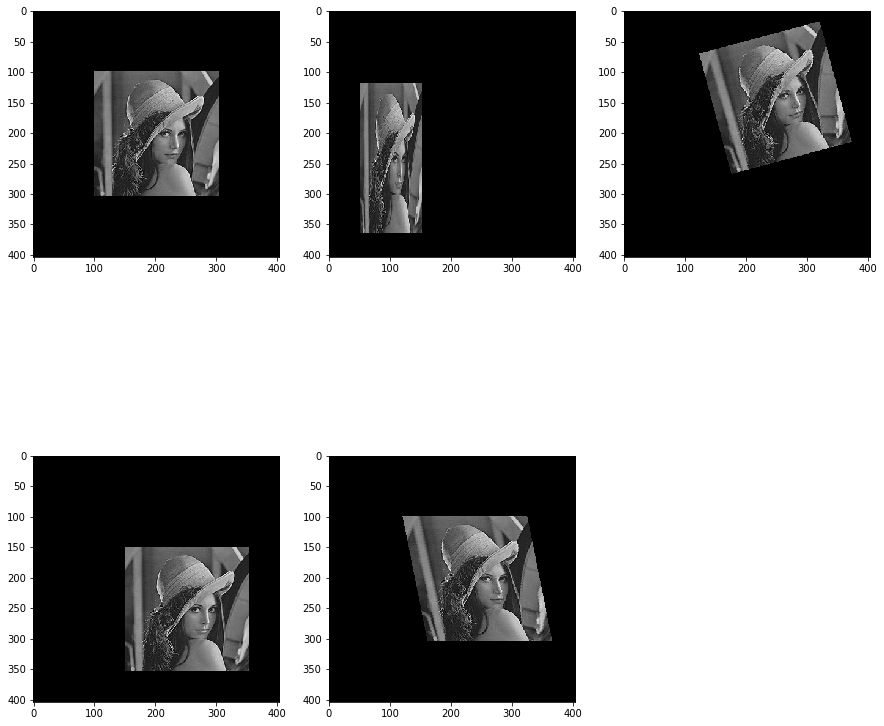

In [110]:
plt.figure(figsize = (15, 15))
# 恒等变换
Delta = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
plt.subplot(231)
plt.imshow(transform(img, area, Delta), cmap = 'gray')
# 尺度变换
Delta = np.array([[1.2, 0, 0], [0, 0.5, 0], [0, 0, 1]])
plt.subplot(232)
plt.imshow(transform(img, area, Delta), cmap = 'gray')
# 旋转变换
deg = np.pi / 12
Delta = np.array([[np.cos(deg), np.sin(deg), 0], [-np.sin(deg), np.cos(deg), 0], [0, 0, 1]])
plt.subplot(233)
plt.imshow(transform(img, area, Delta), cmap = 'gray')
# 平移变换
Delta = np.array([[1, 0, 0], [0, 1, 0], [50, 50, 1]])
plt.subplot(234)
plt.imshow(transform(img, area, Delta), cmap = 'gray')
# 偏移变换
Delta = np.array([[1, 0.2, 0], [0, 1, 0], [0, 0, 1]])
plt.subplot(235)
plt.imshow(transform(img, area, Delta), cmap = 'gray')
plt.show()